In [1]:
import autoreload
%load_ext autoreload
%autoreload 2

 # Patch clamp analysis

In [2]:
import matplotlib.pyplot as plt
from patch_clamp_functions import *

 ## sEPSC demo trace

In [3]:
sEPSCparser = epsc_parser()
print(len(sEPSCparser.files["abf"]))

95


 ### representative trace

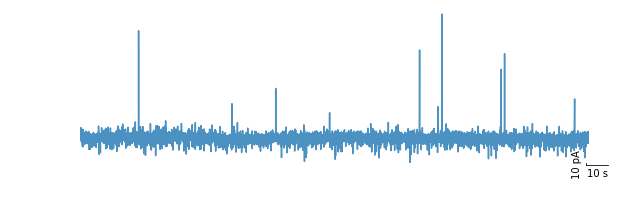

In [4]:
sEPSCparser.plot_demo_epsc(80)

 ## cumulative distribution

Text(0, 0.5, 'Cumulative Fraction')

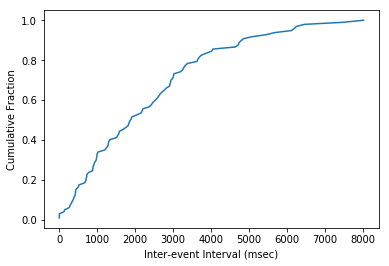

In [5]:
itiDemoData = sEPSCparser.read_demo_stat_data('iti', 0)

plt.plot(itiDemoData["Inter-event Interval (msec)"], itiDemoData["Cumulative Fraction"])
plt.xlabel("Inter-event Interval (msec)")
plt.ylabel("Cumulative Fraction")
# plt.savefig('cumulative_sEPSP_ITI',dpi=600)

Text(0, 0.5, 'Cumulative Fraction')

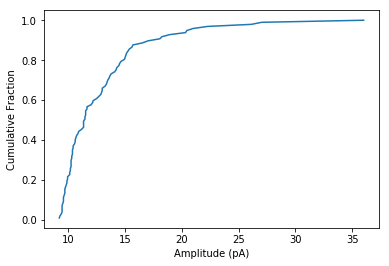

In [6]:
ampDemoData = sEPSCparser.read_demo_stat_data('amp', 0)
plt.plot(ampDemoData["Amplitude (pA)"], ampDemoData["Cumulative Fraction"])
plt.xlabel("Amplitude (pA)")
plt.ylabel("Cumulative Fraction")
# plt.savefig('cumulative_sEPSP_amplitute',dpi=600)

 ## AP demo trace

 ### raw trace

In [7]:
ap_ps = ap_parser()
print(len(ap_ps.files['abf']))

115


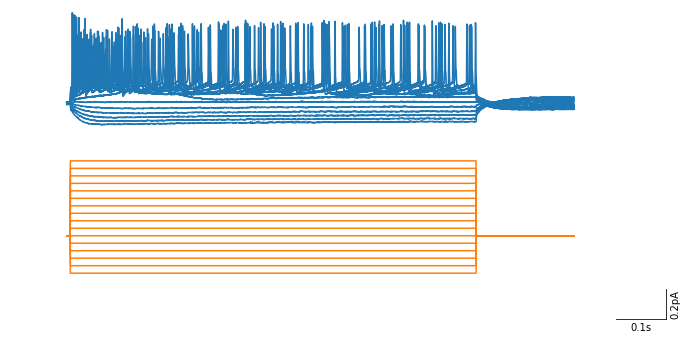

In [8]:
ap_ps.plot_demo_ap(82)

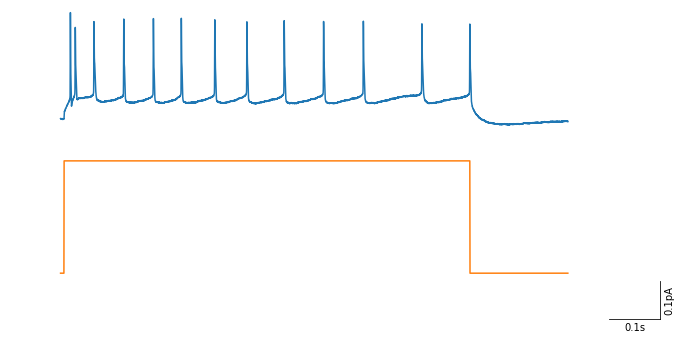

In [9]:
ap_ps.plot_demo_ap(54, sweep=12)

 ### AP distribution

In [10]:
ap_ps = ap_parser()
fitDemoData = ap_ps.read_demo_fit_stat(0)
fitDemoData.head()

,filename,sweep,AP_ID,Amplitude,Time,Baseline,Rise,Area,Half-width,Burst#,...,Peak,Peak2AH,Threshold,Width,AHP Area,Decay%,col_17,col_18,col_19,col_20
0,19408000.abf,7,1,51.941,18154.8,-13.489,5.0,1470.215,36.4,0.0,...,0.0,42.4,-6.409,34.044,-563.049,-12.268,34.8,0,0,0
1,19408000.abf,7,2,48.218,18309.2,-10.742,4.2,1138.574,29.6,0.0,...,0.0,36.6,-4.028,26.087,-783.044,-15.076,28.6,0,0,0
2,19408000.abf,7,3,48.035,18448.8,-10.864,4.2,1118.640,29.0,0.0,...,0.0,36.0,-3.113,22.556,-780.103,-14.709,28.2,0,0,0
3,19408000.abf,7,4,47.363,18593.2,-10.620,4.4,1117.212,29.2,0.0,...,0.0,36.2,-2.991,23.179,-768.628,-14.771,28.2,0,0,0
4,19408000.abf,7,5,46.326,18729.8,-10.681,4.6,1139.233,30.2,0.0,...,0.0,37.4,3.967,9.316,-729.553,-15.137,29.4,0,0,0


In [11]:
EvDemoData = ap_ps.read_demo_event_stat(0)
EvDemoData.head()

,Time (ms),Amplitude,Rise (ms),Decay (ms),Area,Baseline,Noise,Group,Channel,10-90Rise,HalfWidth,Rise50,Peak Dir,Burst#,BurstE#,10-90Slope,Rel Time,Identifier
0,18179.0,116.760,1.0,0.8,123.14,-44.556,-0.183,7,0,0.36,0.97,0.6,1,0,0,258.38,54.2,12d27000
1,18494.2,121.704,1.0,1.0,128.42,-44.128,-0.061,7,0,0.34,0.95,0.4,1,0,0,289.06,62.2,12d27000
2,21117.6,120.239,8.0,0.8,152.92,-48.645,0.610,8,0,0.38,0.97,0.6,1,0,0,250.31,228.0,12d27000
3,21140.2,118.225,2.0,1.0,134.86,-47.424,-0.122,8,0,0.36,1.02,0.4,1,0,0,265.77,250.6,12d27000
4,21276.4,117.371,1.4,1.0,125.76,-43.213,-0.366,8,0,0.36,0.98,0.4,1,0,0,262.93,79.6,12d27000


In [12]:
IFdemoData = ap_ps.get_demo_IF_data(0)
IFallData = ap_ps.get_all_data('IF')

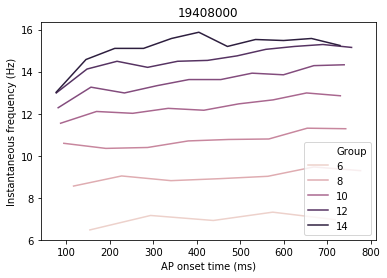

In [13]:
ap_ps.plot_demo_IF(4)

In [14]:
IFstat = get_CV_of_IF(IFallData)

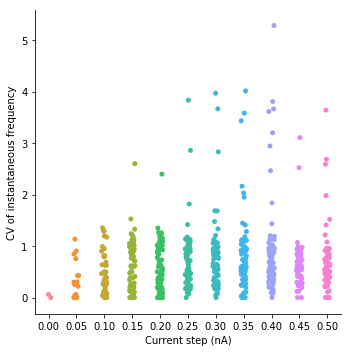

In [15]:
plot_IF_CV_distribution(IFstat)

 ### AP frequency

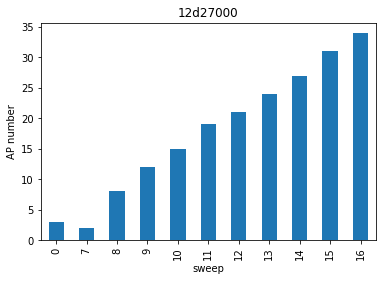

In [16]:
ap_ps.plot_demo_distribution('freq', 0)

In [17]:
apAllFreqData = ap_ps.get_all_data('freq')

 ### AP amplitude

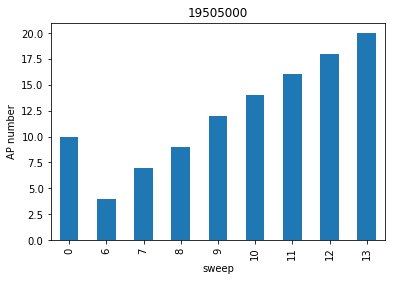

In [18]:
ap_ps.plot_demo_distribution('amp', 12)

 ## time constant (tau)

 Read tau results

In [19]:
tauData = ap_ps.get_all_data('tau')
tauData.head()

,File Name,CellID,Signal,Trace,Trace Start (ms),Fit Function,Best Number of Terms,A,S.E.,tau,...,Cursor 3 Intercept,Cursor 4 Intercept,Correlation Coefficient,Standard Deviation,Sum of Squared Errors,Sum of Data Squared,Points Fitted,Fitted Area,Results,File Path
0,19n29000.abf,19n29000,Cur_Clamp0,1,0,"Exponential, standard, 1st Order",N/A,2.63910,0.139812,4.09301,...,N/A,N/A,0.995176,0.331815,88.081,3.78465e+006,801,10997.9,Successful fit.,F:\Fan Zuquan\AP\20191129\cell1\
1,19n29000.abf,19n29000,Cur_Clamp0,2,5000,"Exponential, standard, 1st Order",N/A,1.25283,0.101658,8.74142,...,N/A,N/A,0.995011,0.343756,94.5343,3.79867e+006,801,11018.2,Successful fit.,F:\Fan Zuquan\AP\20191129\cell1\
2,19n29000.abf,19n29000,Cur_Clamp0,3,10000,"Exponential, standard, 1st Order",N/A,2.12874,0.112776,6.57852,...,N/A,N/A,0.99516,0.333278,88.8596,3.79266e+006,801,11009.5,Successful fit.,F:\Fan Zuquan\AP\20191129\cell1\
3,19n29000.abf,19n29000,Cur_Clamp0,4,15000,"Exponential, standard, 1st Order",N/A,1.27603,0.10632,7.69664,...,N/A,N/A,0.995097,0.338385,91.6033,3.81021e+006,801,11034.9,Successful fit.,F:\Fan Zuquan\AP\20191129\cell1\
4,19n29000.abf,19n29000,Cur_Clamp0,5,20000,"Exponential, standard, 1st Order",N/A,2.04455,0.112786,6.51330,...,N/A,N/A,0.995192,0.331752,88.0474,3.80941e+006,801,11033.8,Successful fit.,F:\Fan Zuquan\AP\20191129\cell1\


### filter outlier

In [20]:
ap_ps.is_outlier().head()

,CellID,tau,C,isOutlier
0,,50.067900,-0.000000,False
1,12d27000,2.544888,-0.037321,False
2,12d27007,65.885062,-0.015410,False
3,12d30000,35.837413,-0.005889,False
4,12d30003,-120.654656,-0.052336,True


### time constant statistic

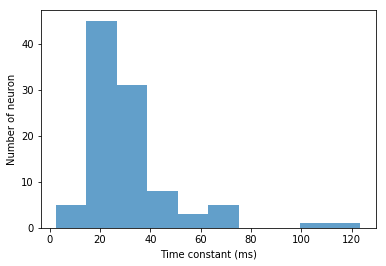

In [21]:
ap_ps.plot_tau_distribution()

 ## I/V relationship

 ### plot I-V traces

In [22]:
ivAllData = ap_ps.get_all_data('iv')
ivAllData.head()

,File Name,CellID,Trace,Trace Start (ms),Signal 1,Region 1,Start Time R1 (ms),End Time R1 (ms),Vm,File Path,I
0,19408008.abf,19408008,1,0,Cur_Clamp,Cursors 3..4,577,885.8,-85.5854,E:\data\patch\AP\20190408\cell 1\,-0.20
1,19408008.abf,19408008,2,5000,Cur_Clamp,Cursors 3..4,577,885.8,-77.3404,E:\data\patch\AP\20190408\cell 1\,-0.15
2,19408008.abf,19408008,3,10000,Cur_Clamp,Cursors 3..4,577,885.8,-68.9896,E:\data\patch\AP\20190408\cell 1\,-0.10
3,19408008.abf,19408008,4,15000,Cur_Clamp,Cursors 3..4,577,885.8,-59.7691,E:\data\patch\AP\20190408\cell 1\,-0.05
4,19408008.abf,19408008,5,20000,Cur_Clamp,Cursors 3..4,577,885.8,-46.6174,E:\data\patch\AP\20190408\cell 1\,0.00


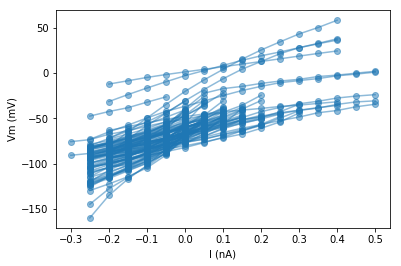

In [23]:
plot_iv_traces(ivAllData, to_save="IV_trace")

 ### Compute membrane resistance

In [24]:
RmRes = compute_Rm(ivAllData)
RmRes.head()

,CellID,R_score,Rm
0,12d27000,0.990183,144.654055
1,12d30003,0.976966,130.907212
2,19408000,0.988642,240.104054
3,19408008,0.979738,214.399711
4,19417000,0.988567,273.753396


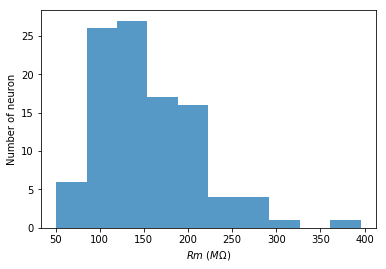

In [25]:
plot_Rm_distribution(RmRes, to_save="Rm_hist")

 ## ramp current triggered voltage

In [26]:
from patch_clamp_functions import ramp_parser
ramp_ps = ramp_parser()

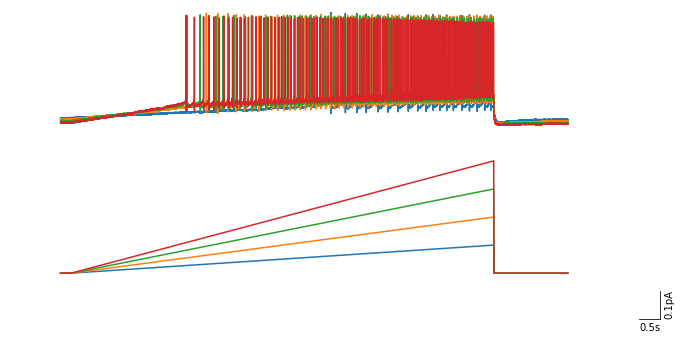

In [27]:
ramp_ps.plot_demo_ramp(20)

 # Morphological analysis

In [28]:
from morphological_functions import morpho_parser
mpp = morpho_parser()

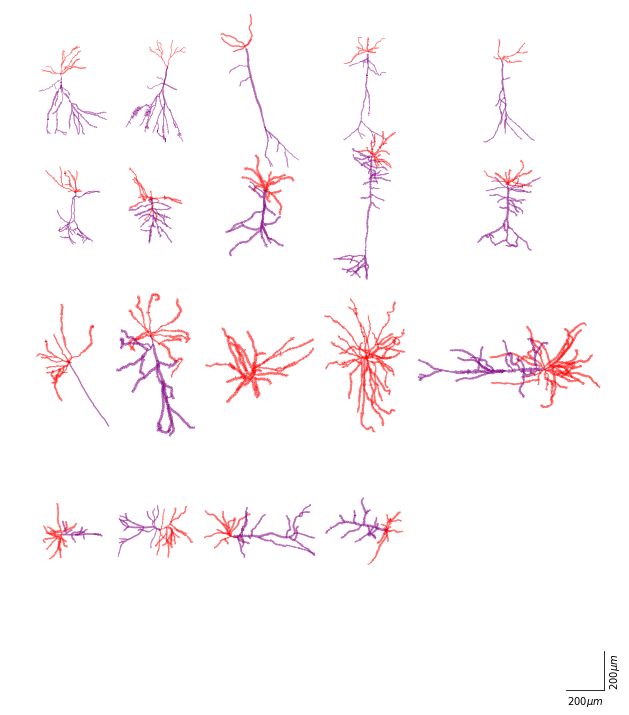

In [116]:
mpp.plot_all_neurons()

 Put apical dendrites upside:

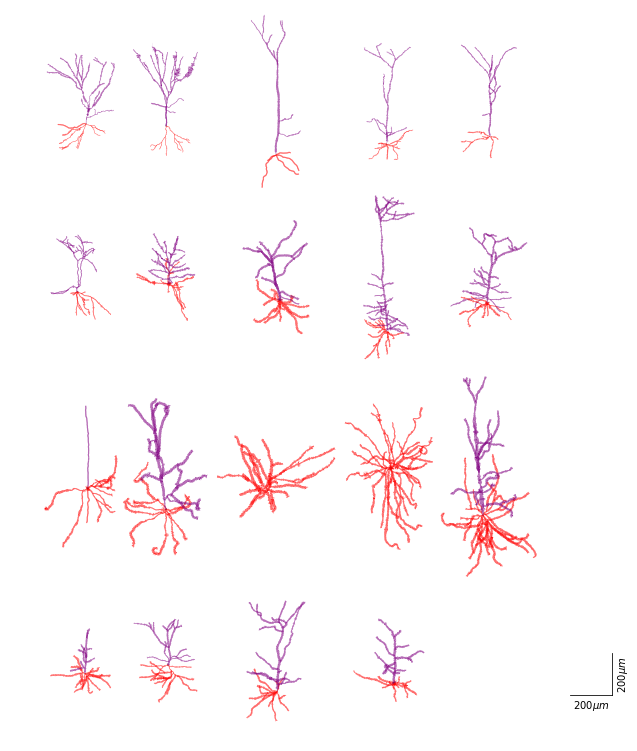

In [115]:
mpp.plot_apical_upside()

 ## Sholl analysis

 Analyse by neurom:

In [31]:
shollParts = mpp.get_sholl_parts_stat()
shollParts.head()

,radius,intersections,label,id
1,1,1.0,apical,20190620_neuron3
2,2,1.0,apical,20190620_neuron3
3,3,1.0,apical,20190620_neuron3
4,4,1.0,apical,20190620_neuron3
5,5,1.0,apical,20190620_neuron3


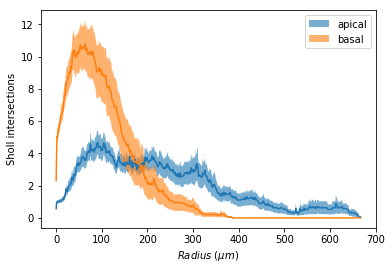

In [32]:
mpp.plot_sholl(sholl_part=True)

 Analyse by morphological data exported by Imaris:

In [33]:
morphoData = mpp.get_imaris_stat()
morphoData.head()

,Category,Collection,Default Labels,Dendrite Area,Depth,Distance,FilamentID,ID,Level,Radius,Time,Type,Unit,Unnamed: 14,Unnamed: 9,Value,Variable,neuron_ID
0,Dendrite,NaN,basal,NaN,1.0,NaN,100000000.0,510000000001,1.0,NaN,1,NaN,um^2,NaN,NaN,41.5376,Dendrite Area,20190620_neuron3
1,Dendrite,NaN,basal,NaN,2.0,NaN,100000000.0,510000000067,2.0,NaN,1,NaN,um^2,NaN,NaN,14.9117,Dendrite Area,20190620_neuron3
2,Dendrite,NaN,basal,NaN,3.0,NaN,100000000.0,510000000090,2.0,NaN,1,NaN,um^2,NaN,NaN,122.4580,Dendrite Area,20190620_neuron3
3,Dendrite,NaN,basal,NaN,3.0,NaN,100000000.0,510000000346,3.0,NaN,1,NaN,um^2,NaN,NaN,107.6860,Dendrite Area,20190620_neuron3
4,Dendrite,NaN,basal,NaN,2.0,NaN,100000000.0,510000000567,1.0,NaN,1,NaN,um^2,NaN,NaN,131.9460,Dendrite Area,20190620_neuron3


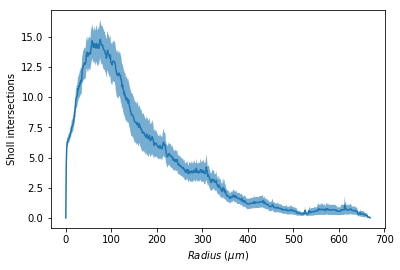

In [34]:
mpp.plot_sholl(sholl_part=False)

 ## angle distribution

 ## branch order

In [35]:
depthData=mpp.get_depth_data()
depthData.head()

,neuron_ID,Depth,counts
0,20190620_neuron3,1,4
1,20190620_neuron3,2,6
2,20190620_neuron3,3,10
3,20190620_neuron3,4,11
4,20190620_neuron3,5,8


/opt/conda/envs/clamp/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/envs/clamp/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


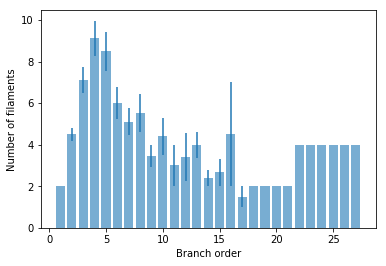

In [36]:
mpp.plot_depth()

 # Cluster Analysis

 ## Electrophysiological Parameters

 Get all electrophysiological data

In [37]:
elec_ps=electro_parser()
electroParaData_py=elec_ps.get_all_data()
electroParaData_py.head()

featureName,CellID,trace,AP1_amp,AP2_amp,APlast_amp,ISI_log_slope,ISI_semilog_slope,inv_first_ISI,inv_last_ISI,inv_second_ISI,inv_third_ISI,inv_time_to_first_spike,mean_AHP_depth_abs,mean_AHP_depth_abs_slow,mean_AHP_time_from_peak,mean_AP_duration_half_width,mean_AP_width,number_initial_spikes,steady_state_voltage_stimend,time_to_last_spike
0,12d27000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-93.293304,NaN
1,12d27000,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.013916,NaN
2,12d27000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-81.152687,NaN
3,12d27000,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.859940,NaN
4,12d27000,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-65.910873,NaN


In [38]:
electroParaData_loc = elec_ps.get_all_data(method='local')
electroParaData_loc.head()

,CellID,Rm,RMP,tau,isOutlier,n,Freq (Hz),CV_of_IF
0,12d27000,144.654055,-57.2191,2.544888,False,24.0,31.546,0.266226
1,12d30003,130.907212,-57.6961,-120.654656,True,21.0,26.656,0.462496
2,19408000,240.104054,-41.5146,47.788854,False,13.0,17.813,0.043280
3,19408008,214.399711,-46.6174,36.750831,False,15.0,19.868,0.089893
4,19417000,273.753396,-60.3334,32.339608,False,29.0,36.323,0.453037


In [39]:
electroParaData = elec_ps.get_all_data(method='all')
electroParaData.head()

Cannot compute rheobase for `19807002.abf` trace 1
Cannot compute rheobase for `19807006.abf` trace 1


,cellID_ap,recording_date,recording_cell_id,cellID_epsc,cellID_ramp,Rm,RMP,tau,isOutlier,n,...,mean_AHP_time_from_peak,mean_AP_duration_half_width,mean_AP_width,number_initial_spikes,steady_state_voltage_stimend,time_to_last_spike,ramp_slope,threshold_I,threshold_V,ramp_spiking_time
0,19408008,20190408,1,19408001,NaN,214.399711,-46.6174,36.750831,False,15.0,...,0.300000,270.450000,398.900000,1.0,3.846474,801.2,NaN,NaN,NaN,NaN
1,19408000,20190408,2,19408003,NaN,240.104054,-41.5146,47.788854,False,13.0,...,0.200000,4.000000,6.800000,1.0,8.026085,8.8,NaN,NaN,NaN,NaN
2,19417000,20190417,1,19417000,NaN,273.753396,-60.3334,32.339608,False,29.0,...,3.151724,1.165517,3.613793,5.0,-22.068901,802.0,NaN,NaN,NaN,NaN
3,19417001,20190417,2,19417001,NaN,196.419483,-69.6677,26.784438,False,22.0,...,3.000000,1.000000,2.890909,4.0,-30.863075,775.2,NaN,NaN,NaN,NaN
4,19417002,20190417,3,19417002,NaN,248.124996,-40.5830,69.147185,False,44.0,...,2.418605,NaN,2.509302,4.0,-22.681007,755.2,NaN,NaN,NaN,NaN


## Morphological Parameters

In [40]:
morphoData = mpp.get_all_data()
morphoData.head()

,reconstruction_ID,Filament Area (sum),Filament Dendrite Area (sum),Filament Dendrite Length (sum),Filament Dendrite Volume (sum),Filament Distance from Origin,Filament Full Branch Depth,Filament Full Branch Level,Filament Length (sum),Filament No. Dendrite Branch Pts,...,number_of_bifurcations,number_of_forking_points,number_of_neurites,number_of_sections,number_of_sections_per_neurite,number_of_segments,number_of_terminations,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal)
0,20190620_neuron3,10910.00,10910.00,4083.05,2821.49,305.977,8.0,6.0,4083.05,26.0,...,25.0,26.0,4.0,57.0,37.0,10687.0,31.0,4081.369879,2834.939985,1246.429894
1,20190621_neuron5,11333.90,11333.90,4358.37,3911.53,342.625,13.0,6.0,4358.37,46.0,...,46.0,46.0,4.0,96.0,71.0,10620.0,50.0,4357.301279,3468.067435,889.233843
2,20190630_neuron1,6855.76,6855.76,2014.88,2291.71,446.037,7.0,3.0,2014.88,7.0,...,7.0,7.0,6.0,20.0,15.0,2518.0,13.0,2007.632353,1376.187560,631.444793
3,20190630_neuron2,7529.28,7529.28,2988.55,1775.40,425.158,9.0,5.0,2988.55,28.0,...,27.0,27.0,6.0,60.0,3.0,11625.0,33.0,2987.019948,2070.660314,916.359634
4,20190701_neuron4,6091.93,6091.93,2058.37,1589.63,327.495,9.0,3.0,2058.37,18.0,...,18.0,18.0,3.0,39.0,27.0,2040.0,21.0,2053.981315,1499.087247,554.894068


 ## analysis

In [41]:
from neuron_cluster_analysis import cluster_processor
analysor = cluster_processor(elec_ps,mpp)
cluster_data = analysor.get_all_data('inner')
cluster_data.head()

,cellID_ap,recording_date,recording_cell_id,cellID_epsc,cellID_ramp,Rm,RMP,tau,isOutlier,n,...,number_of_bifurcations,number_of_forking_points,number_of_neurites,number_of_sections,number_of_sections_per_neurite,number_of_segments,number_of_terminations,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal)
0,19612002,20190612,4,NaN,NaN,126.673046,-65.7994,26.651977,False,4.0,...,25.0,26.0,4.0,57.0,37.0,10687.0,31.0,4081.369879,2834.939985,1246.429894
1,19612003,20190612,5,NaN,NaN,97.830327,-67.4632,36.350580,False,NaN,...,46.0,46.0,4.0,96.0,71.0,10620.0,50.0,4357.301279,3468.067435,889.233843
2,19626000,20190626,1,19626001,NaN,133.875355,-71.0943,25.419869,False,10.0,...,7.0,7.0,6.0,20.0,15.0,2518.0,13.0,2007.632353,1376.187560,631.444793
3,19626002,20190626,2,NaN,NaN,127.392784,-72.7821,24.653300,False,6.0,...,27.0,27.0,6.0,60.0,3.0,11625.0,33.0,2987.019948,2070.660314,916.359634
4,19626005,20190626,4,NaN,NaN,158.948569,-74.6864,20.567454,False,20.0,...,18.0,18.0,3.0,39.0,27.0,2040.0,21.0,2053.981315,1499.087247,554.894068


 ### K-Means

Analyze electrophysiological data and morphological data:

In [42]:
km = analysor.k_means()
km.head()

/home/data/patch/analysis/20191107/neuron_cluster_analysis.py:91: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  ca_dat_scaled = preprocessing.scale(ca_dat_filled)


,cellID_ap,Rm,RMP,tau,n,Freq (Hz),CV_of_IF,AP1_amp,AP2_amp,APlast_amp,...,number_of_forking_points,number_of_neurites,number_of_sections,number_of_sections_per_neurite,number_of_segments,number_of_terminations,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal),cluster
0,19612002,126.673046,-65.7994,26.651977,4.0,18.100,0.462213,NaN,NaN,NaN,...,26.0,4.0,57.0,37.0,10687.0,31.0,4081.369879,2834.939985,1246.429894,1
1,19612003,97.830327,-67.4632,36.350580,NaN,NaN,NaN,148.742676,NaN,148.742676,...,46.0,4.0,96.0,71.0,10620.0,50.0,4357.301279,3468.067435,889.233843,1
2,19626000,133.875355,-71.0943,25.419869,10.0,14.160,1.088870,169.982910,112.365723,106.079102,...,7.0,6.0,20.0,15.0,2518.0,13.0,2007.632353,1376.187560,631.444793,1
3,19626002,127.392784,-72.7821,24.653300,6.0,10.909,1.409690,153.442383,65.917969,75.927734,...,27.0,6.0,60.0,3.0,11625.0,33.0,2987.019948,2070.660314,916.359634,1
4,19626005,158.948569,-74.6864,20.567454,20.0,26.518,0.586973,177.459717,73.486328,113.342285,...,18.0,3.0,39.0,27.0,2040.0,21.0,2053.981315,1499.087247,554.894068,1


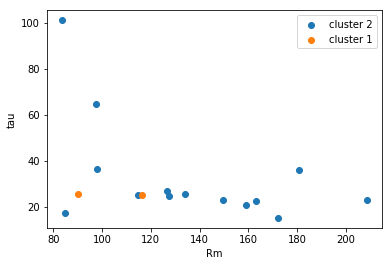

In [43]:
analysor.plot_cluster_scatter('Rm','tau')

Not well.

Only analyze electrophysiological data:

In [44]:
cluster_data_e = analysor.elec_ps.get_all_data(method="all")
cluster_data_e.head()

,cellID_ap,recording_date,recording_cell_id,cellID_epsc,cellID_ramp,Rm,RMP,tau,isOutlier,n,...,mean_AHP_time_from_peak,mean_AP_duration_half_width,mean_AP_width,number_initial_spikes,steady_state_voltage_stimend,time_to_last_spike,ramp_slope,threshold_I,threshold_V,ramp_spiking_time
0,19408008,20190408,1,19408001,NaN,214.399711,-46.6174,36.750831,False,15.0,...,0.300000,270.450000,398.900000,1.0,3.846474,801.2,NaN,NaN,NaN,NaN
1,19408000,20190408,2,19408003,NaN,240.104054,-41.5146,47.788854,False,13.0,...,0.200000,4.000000,6.800000,1.0,8.026085,8.8,NaN,NaN,NaN,NaN
2,19417000,20190417,1,19417000,NaN,273.753396,-60.3334,32.339608,False,29.0,...,3.151724,1.165517,3.613793,5.0,-22.068901,802.0,NaN,NaN,NaN,NaN
3,19417001,20190417,2,19417001,NaN,196.419483,-69.6677,26.784438,False,22.0,...,3.000000,1.000000,2.890909,4.0,-30.863075,775.2,NaN,NaN,NaN,NaN
4,19417002,20190417,3,19417002,NaN,248.124996,-40.5830,69.147185,False,44.0,...,2.418605,NaN,2.509302,4.0,-22.681007,755.2,NaN,NaN,NaN,NaN


In [45]:
km_e = analysor.k_means(
    cluster_data_e, n_cluster=3,random_state=17
)
km_e.head()

,cellID_ap,Rm,RMP,tau,n,Freq (Hz),CV_of_IF,AP1_amp,AP2_amp,APlast_amp,...,mean_AHP_time_from_peak,mean_AP_duration_half_width,mean_AP_width,number_initial_spikes,steady_state_voltage_stimend,time_to_last_spike,threshold_I,threshold_V,ramp_spiking_time,cluster
0,19408008,214.399711,-46.6174,36.750831,15.0,19.868,0.089893,84.259033,NaN,84.259033,...,0.300000,270.450000,398.900000,1.0,3.846474,801.2,NaN,NaN,NaN,2
1,19408000,240.104054,-41.5146,47.788854,13.0,17.813,0.043280,79.986572,NaN,79.986572,...,0.200000,4.000000,6.800000,1.0,8.026085,8.8,NaN,NaN,NaN,1
2,19417000,273.753396,-60.3334,32.339608,29.0,36.323,0.453037,181.701660,135.498047,113.952637,...,3.151724,1.165517,3.613793,5.0,-22.068901,802.0,NaN,NaN,NaN,0
3,19417001,196.419483,-69.6677,26.784438,22.0,28.512,0.271114,187.225342,136.657715,127.349854,...,3.000000,1.000000,2.890909,4.0,-30.863075,775.2,NaN,NaN,NaN,0
4,19417002,248.124996,-40.5830,69.147185,44.0,58.542,NaN,NaN,NaN,NaN,...,2.418605,NaN,2.509302,4.0,-22.681007,755.2,NaN,NaN,NaN,1


### PCA scatter plot

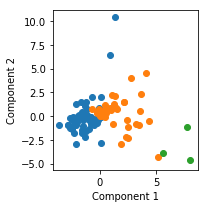

In [46]:
pca_dat = analysor.k_means(
    cluster_data_e, n_cluster=3,return_filled=True, 
    random_state=17,return_scaled=True)
analysor.plot_decomposition_scatter(
    ca_dat=pca_dat, to_save='PCA_dim1_2',
    show_legend=False
)

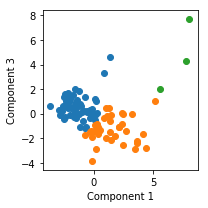

In [47]:
analysor.plot_decomposition_scatter(
    ca_dat=pca_dat,dim2=2,
    to_save='PCA_dim1_3',
    show_legend=False
)

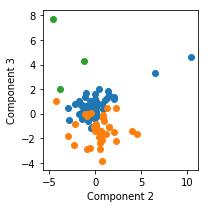

In [48]:
analysor.plot_decomposition_scatter(
    ca_dat=pca_dat,dim1=1,dim2=2,
    to_save='PCA_dim2_3',
    show_legend=False
)

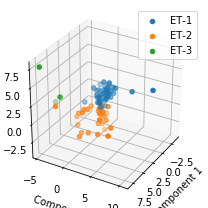

In [49]:
analysor.plot_decomposition_scatter(
    ca_dat=pca_dat, to_save='PCA_dim123',
    plot_3d=True,
    label_map={0:'ET-1',1:'ET-2',2:'ET-3'}
)

### Inter-class comparation

In [50]:
inter_class_stat_e = analysor.stat_analyse(
    km_e.drop(columns="cellID_ap"),
#     test_small_sample=True,
    group1=0, group2=1
)
inter_class_stat_e

,variable,stat_method,p_value
0,Rm,Kruskal-Wallis H-test,1.926482e-04
1,RMP,Kruskal-Wallis H-test,1.990950e-04
2,tau,Kruskal-Wallis H-test,3.642970e-03
3,n,Kruskal-Wallis H-test,3.002474e-01
4,Freq (Hz),Kruskal-Wallis H-test,5.712950e-02
5,CV_of_IF,Kruskal-Wallis H-test,6.439714e-01
6,AP1_amp,t_test,9.736108e-03
7,AP2_amp,t_test,1.341038e-01
8,APlast_amp,t_test,3.985592e-02
9,ISI_log_slope,Kruskal-Wallis H-test,2.372371e-03


In [51]:
inter_class_stat_e[inter_class_stat_e.p_value<0.05].variable.to_list()

['Rm',
 'RMP',
 'tau',
 'AP1_amp',
 'APlast_amp',
 'ISI_log_slope',
 'ISI_semilog_slope',
 'inv_first_ISI',
 'inv_last_ISI',
 'inv_second_ISI',
 'inv_third_ISI',
 'mean_AHP_depth_abs',
 'mean_AHP_depth_abs_slow',
 'mean_AHP_time_from_peak',
 'mean_AP_width',
 'number_initial_spikes',
 'steady_state_voltage_stimend',
 'threshold_V',
 'ramp_spiking_time']

/opt/conda/envs/clamp/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/envs/clamp/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/envs/clamp/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


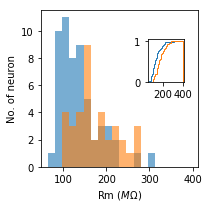

In [52]:
from neuron_cluster_analysis import plot_cluster_hist

plot_cluster_hist(
    km_e, "Rm", xlabel="Rm " + "$(M\Omega)$", 
    group1=0, group2=1, 
    to_save='Rm_clusters',
    plot_cumulative=True, 
#     legend_kw={"loc": 4}
    show_legend=False
)

/opt/conda/envs/clamp/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


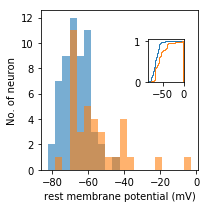

In [53]:
plot_cluster_hist(
    km_e, "RMP", 
    xlabel="rest membrane potential (mV)", 
    group1=0, group2=1,
    plot_cumulative=True,
    to_save='RMP_clusters',
#     legend_kw={"loc": 5},
    show_legend=False
)

/opt/conda/envs/clamp/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


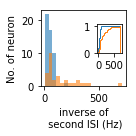

In [174]:
plot_cluster_hist(
    km_e, "inv_second_ISI", 
    xlabel="inverse of\n second ISI (Hz)", 
    group1=0, group2=1,
    plot_cumulative=True, 
#     legend_kw={"loc": 5}
    show_legend=False,
    fig_size=(2,2),
    to_save='inv_second_ISI_hist'
)

/opt/conda/envs/clamp/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


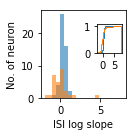

In [173]:
plot_cluster_hist(
    km_e, "ISI_log_slope", 
    xlabel="ISI log slope", 
#     group1=0, group2=2,
    plot_cumulative=True, 
#     legend_kw={"loc": 4},
    show_legend=False,
    fig_size=(2,2),
    to_save='ISI_log_slope'
)

In [56]:
clust1_id = km_e[km_e.cluster == 0].cellID_ap.values
clust2_id = km_e[km_e.cluster == 1].cellID_ap.values

/opt/conda/envs/clamp/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


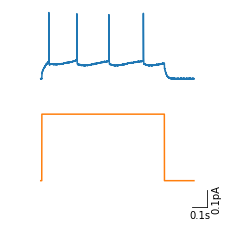

In [110]:
from neuron_cluster_analysis import select_demo_cell_id
id_select = select_demo_cell_id(km_e, 'inv_first_ISI')
analysor.plot_demo_ap(sweep=13, cell_id=id_select[0],
                     to_save='demo_ET1_ap',
                     fig_size=(3,1.5))

/opt/conda/envs/clamp/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


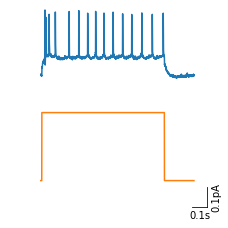

In [111]:
analysor.plot_demo_ap(sweep=13, cell_id=id_select[1],
                     to_save='demo_ET2_ap',
                     fig_size=(3,1.5))

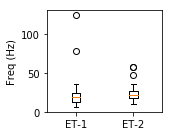

In [59]:
from neuron_cluster_analysis import plot_cluster_stat
plot_cluster_stat(
    km_e, 'Freq (Hz)', plot_box=True,
    clusters=(0,1),
    xticks=['ET-1','ET-2'],
    ylabel='Freq (Hz)',
    to_save='Freq_clusters'
)

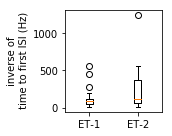

In [90]:
from neuron_cluster_analysis import plot_cluster_stat
plot_cluster_stat(
    km_e, 'inv_first_ISI', plot_box=True,
    xticks=['ET-1','ET-2'],
    ylabel='inverse of\n time to first ISI (Hz)',
    to_save='inv_first_ISI_clusters'
)

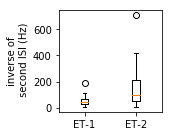

In [91]:
plot_cluster_stat(
    km_e, 'inv_second_ISI', plot_box=True,
    xticks=['ET-1','ET-2'],
    ylabel='inverse of\n second ISI (Hz)',
    to_save='inv_second_ISI_clusters'
)

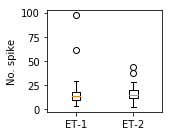

In [92]:
plot_cluster_stat(km_e, 'n', plot_box=True,
                  xticks=['ET-1','ET-2'],
                  ylabel='No. spike',
                  to_save='spike_n_clusters')

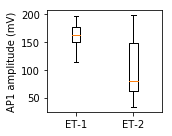

In [112]:
plot_cluster_stat(
    km_e, 'AP1_amp', plot_box=True,
    xticks=['ET-1','ET-2'],
    ylabel='AP1 amplitude (mV)',
    to_save='AP1_amp_clusters'
)

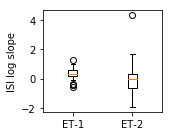

In [94]:
plot_cluster_stat(
    km_e, 'ISI_log_slope', plot_box=True,
    xticks=['ET-1','ET-2'],
    ylabel='ISI log slope',
    to_save='ISI_log_slope_clusters'
)

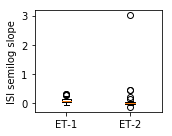

In [95]:
plot_cluster_stat(
    km_e, 'ISI_semilog_slope', plot_box=True,
    xticks=['ET-1','ET-2'],
    ylabel='ISI semilog slope',
    to_save='ISI_semilog_slope_clusters'
)

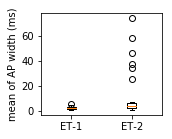

In [96]:
plot_cluster_stat(
    km_e, 'mean_AP_width',
    xticks=['ET-1','ET-2'],
    ylabel='mean of AP width (ms)',
    to_save='mean_AP_width_clusters',
    plot_box=True
)

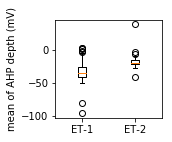

In [97]:
plot_cluster_stat(
    km_e, 'mean_AHP_depth_abs',
    xticks=['ET-1','ET-2'],
    ylabel='mean of AHP depth (mV)',
    to_save='mean_AHP_depth_abs_clusters',
    plot_box=True
)

Plot ramp current of cluster 1

/opt/conda/envs/clamp/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


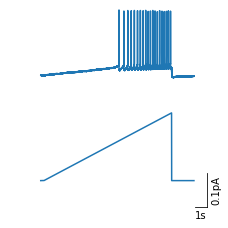

In [106]:
analysor.elec_ps.plot_demo_ramp(
    cell_id='19n11001', sweep=2,
    to_save='demo_ET1_ramp'
)

Plot ramp current of cluster 2

/opt/conda/envs/clamp/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


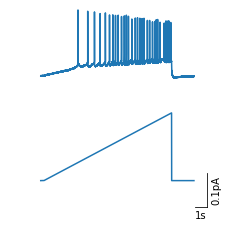

In [107]:
analysor.elec_ps.plot_demo_ramp(
    cell_id='19n14006', sweep=2,
    to_save='demo_ET2_ramp'
)

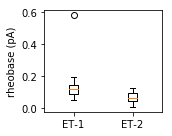

In [104]:
plot_cluster_stat(
    km_e, 'threshold_I',
    xticks=['ET-1','ET-2'],
    ylabel='rheobase (pA)',
    to_save='rheobase_clusters',
    plot_box=True
)

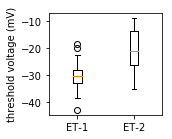

In [105]:
plot_cluster_stat(
    km_e, 'threshold_V',
    xticks=['ET-1','ET-2'],
    ylabel='threshold voltage (mV)',
    to_save='threshold_V_clusters',
    plot_box=True
)

### Morphological classifier

Prepare morphology dataset for SVM training:

In [122]:
from neuron_cluster_analysis import k_means_preprocess
train_dat = analysor.get_morpho_cluster_label(km_e, cluster_data)
morpho_train = train_dat.set_index('cluster')['reconstruction_ID']
train_dat = k_means_preprocess(train_dat)
train_dat = train_dat.drop(columns='cellID_ap').fillna(train_dat.mean())
train_dat.head()

,Filament Area (sum),Filament Dendrite Area (sum),Filament Dendrite Length (sum),Filament Dendrite Volume (sum),Filament Distance from Origin,Filament Full Branch Depth,Filament Full Branch Level,Filament Length (sum),Filament No. Dendrite Branch Pts,Filament No. Dendrite Segments,...,number_of_forking_points,number_of_neurites,number_of_sections,number_of_sections_per_neurite,number_of_segments,number_of_terminations,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal),cluster
0,10910.00,10910.00,4083.05,2821.49,305.977,8.0,6.0,4083.05,26.0,57.0,...,26.0,4.0,57.0,37.0,10687.0,31.0,4081.369879,2834.939985,1246.429894,1
1,11333.90,11333.90,4358.37,3911.53,342.625,13.0,6.0,4358.37,46.0,96.0,...,46.0,4.0,96.0,71.0,10620.0,50.0,4357.301279,3468.067435,889.233843,0
2,6855.76,6855.76,2014.88,2291.71,446.037,7.0,3.0,2014.88,7.0,20.0,...,7.0,6.0,20.0,15.0,2518.0,13.0,2007.632353,1376.187560,631.444793,0
3,7529.28,7529.28,2988.55,1775.40,425.158,9.0,5.0,2988.55,28.0,61.0,...,27.0,6.0,60.0,3.0,11625.0,33.0,2987.019948,2070.660314,916.359634,0
4,6091.93,6091.93,2058.37,1589.63,327.495,9.0,3.0,2058.37,18.0,39.0,...,18.0,3.0,39.0,27.0,2040.0,21.0,2053.981315,1499.087247,554.894068,0


In [73]:
svm_f = analysor.svm_train(train_dat)
y_test = svm_f(train_dat.drop(columns='cluster'))
correct = y_test == train_dat.cluster.values
print('Correct prediction rate: {}'.format(correct.sum()/correct.size))

Correct prediction rate: 1.0


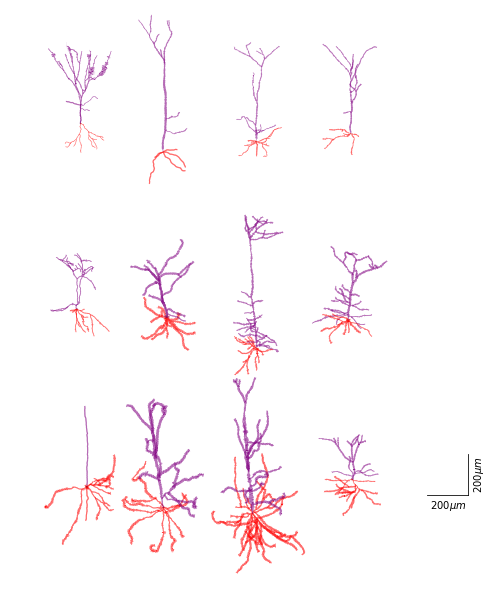

In [152]:
train_c1 = [n for n in mpp.neurons 
            if n.name in morpho_train[0].values]
mpp.plot_apical_upside(train_c1, to_save='train_ET1')

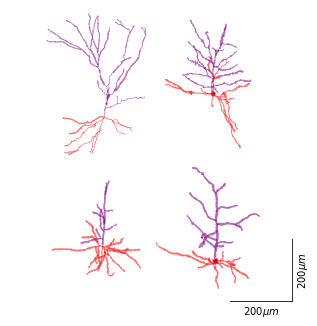

In [153]:
train_c2 = [n for n in mpp.neurons 
            if n.name in morpho_train[1].values]
mpp.plot_apical_upside(train_c2, to_save='train_ET2')

### predict new morphology

#### GFP+ neurons

In [74]:
pred_mpp = morpho_parser({
    "swc": "../../../reconstruction/predict/traces/GFP+_repair",
    "imaris": "../../../reconstruction/predict/stat/GFP+"
})

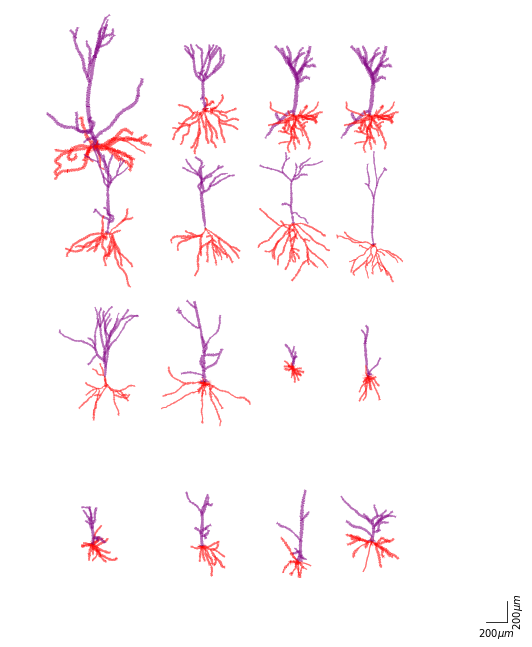

In [157]:
pred_mpp.plot_apical_upside(to_save='GFP+ neurons')

In [77]:
gfp_morpho_dat=pred_mpp.get_all_data()
gfp_morpho_dat.head()

,reconstruction_ID,Filament Area (sum),Filament Dendrite Area (sum),Filament Dendrite Length (sum),Filament Dendrite Volume (sum),Filament Distance from Origin,Filament Full Branch Depth,Filament Full Branch Level,Filament Length (sum),Filament No. Dendrite Branch Pts,...,number_of_bifurcations,number_of_forking_points,number_of_neurites,number_of_sections,number_of_sections_per_neurite,number_of_segments,number_of_terminations,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal)
0,(GFP+)slice_1_red neuron1,109792.0,109792.0,12526.60,87549.1,1001.64,11.0,5.0,12526.60,26.0,...,23.0,25.0,4.0,56.0,23.0,11179.0,31.0,12523.332744,6243.109663,6280.223081
1,GFP+ slice_1 20180615 neuron1,50247.0,50247.0,7899.42,27785.5,1246.49,9.0,5.0,7899.42,33.0,...,33.0,33.0,4.0,70.0,23.0,3964.0,37.0,7888.850106,3082.590921,4806.259186
2,GFP+ slice_3 20180627 neuron1,59913.9,59913.9,8776.89,36720.5,1101.14,9.0,6.0,8776.89,53.0,...,52.0,53.0,3.0,110.0,49.0,7710.0,57.0,8770.851636,3543.358293,5227.493342
3,GFP+ slice_4 20180627 neuron1,59913.9,59913.9,8776.89,36720.5,1101.14,9.0,6.0,8776.89,54.0,...,52.0,53.0,3.0,110.0,49.0,7710.0,57.0,8770.851636,3543.358293,5227.493342
4,GFP+ slice_5 20180627 neuron1,43277.8,43277.8,7343.18,21937.4,1196.57,9.0,6.0,7343.18,41.0,...,41.0,41.0,3.0,85.0,33.0,6269.0,44.0,7336.498926,2657.714468,4678.784458


In [78]:
gfp_cluster=svm_f(gfp_morpho_dat)
gfp_morpho_dat['cluster']=gfp_cluster
gfp_morpho_dat.head()

,reconstruction_ID,Filament Area (sum),Filament Dendrite Area (sum),Filament Dendrite Length (sum),Filament Dendrite Volume (sum),Filament Distance from Origin,Filament Full Branch Depth,Filament Full Branch Level,Filament Length (sum),Filament No. Dendrite Branch Pts,...,number_of_forking_points,number_of_neurites,number_of_sections,number_of_sections_per_neurite,number_of_segments,number_of_terminations,total_length_per_neurite,total_length_per_neurite(apical),total_length_per_neurite(basal),cluster
0,(GFP+)slice_1_red neuron1,109792.0,109792.0,12526.60,87549.1,1001.64,11.0,5.0,12526.60,26.0,...,25.0,4.0,56.0,23.0,11179.0,31.0,12523.332744,6243.109663,6280.223081,0
1,GFP+ slice_1 20180615 neuron1,50247.0,50247.0,7899.42,27785.5,1246.49,9.0,5.0,7899.42,33.0,...,33.0,4.0,70.0,23.0,3964.0,37.0,7888.850106,3082.590921,4806.259186,0
2,GFP+ slice_3 20180627 neuron1,59913.9,59913.9,8776.89,36720.5,1101.14,9.0,6.0,8776.89,53.0,...,53.0,3.0,110.0,49.0,7710.0,57.0,8770.851636,3543.358293,5227.493342,0
3,GFP+ slice_4 20180627 neuron1,59913.9,59913.9,8776.89,36720.5,1101.14,9.0,6.0,8776.89,54.0,...,53.0,3.0,110.0,49.0,7710.0,57.0,8770.851636,3543.358293,5227.493342,0
4,GFP+ slice_5 20180627 neuron1,43277.8,43277.8,7343.18,21937.4,1196.57,9.0,6.0,7343.18,41.0,...,41.0,3.0,85.0,33.0,6269.0,44.0,7336.498926,2657.714468,4678.784458,0


In [165]:
gfp_morpho_inter=analysor.stat_analyse(
    gfp_morpho_dat.drop(columns='reconstruction_ID'),
    group1 = 0, group2 =1,
    test_small_sample=True
)
gfp_morpho_inter[gfp_morpho_inter.p_value<0.05].variable

2              Filament Dendrite Length (sum)
5                  Filament Full Branch Depth
7                       Filament Length (sum)
15                  max_sholl_intercept_radii
16          max_sholl_intercept_radii(apical)
17           max_sholl_intercept_radii(basal)
21                       mean_neurite_lengths
22               mean_neurite_lengths(apical)
23                mean_neurite_lengths(basal)
25        mean_neurite_volume_density(apical)
27                       mean_neurite_volumes
30           mean_principal_direction_extents
32    mean_principal_direction_extents(basal)
46         mean_section_end_distances(apical)
49               mean_section_lengths(apical)
58                   total_length_per_neurite
59           total_length_per_neurite(apical)
60            total_length_per_neurite(basal)
Name: variable, dtype: object

In [154]:
gfp_c1_neurons=[
    n for n in pred_mpp.neurons.neurons
    if n.name in gfp_morpho_dat[gfp_morpho_dat.cluster==0].reconstruction_ID.values
]
gfp_c2_neurons=[
    n for n in pred_mpp.neurons.neurons
    if n.name in gfp_morpho_dat[gfp_morpho_dat.cluster==1].reconstruction_ID.values
]

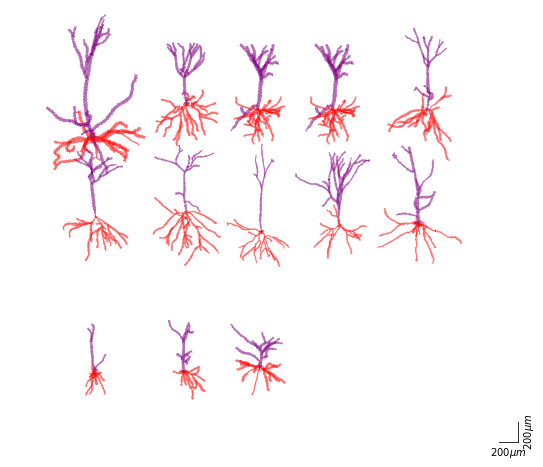

In [162]:
pred_mpp.plot_apical_upside(
    gfp_c1_neurons, to_save='GFP+ ET1',
    fig_size=(7.5,5.5)
)

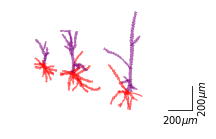

In [163]:
mpp.plot_apical_upside(
    gfp_c2_neurons, fig_size=(3,1.5),
    to_save='GFP+ ET-2'
)

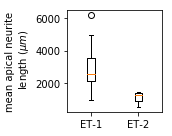

In [185]:
plot_cluster_stat(
    gfp_morpho_dat,'mean_neurite_lengths(apical)',
    ylabel='mean apical neurite\n length ('+'$\mu m)$',
    clusters = (0,1), xticks=['ET-1','ET-2'],
    plot_box=True,
    to_save='mean_neurite_lengths(apical)_gfp_clusters'
)

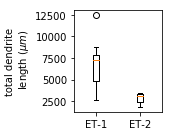

In [187]:
plot_cluster_stat(
    gfp_morpho_dat,'Filament Dendrite Length (sum)',
    ylabel='total dendrite\n length ('+'$\mu m)$',
    clusters = (0,1), xticks=['ET-1','ET-2'],
    plot_box=True,
    to_save='dendrite_lengths_gfp_clusters'
)

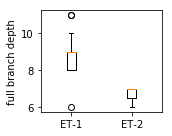

In [189]:
plot_cluster_stat(
    gfp_morpho_dat,'Filament Full Branch Depth',
    ylabel='full branch depth',
    clusters = (0,1), xticks=['ET-1','ET-2'],
    plot_box=True,
    to_save='branch_depth_gfp_clusters'
)

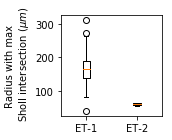

In [194]:
plot_cluster_stat(
    gfp_morpho_dat,'max_sholl_intercept_radii',
    ylabel='Radius with max\n Sholl intersection '+'$(\mu m)$',
    clusters = (0,1), xticks=['ET-1','ET-2'],
    plot_box=True,
    to_save='max_sholl_intercept_radii_gfp_clusters'
)

Sholl intersection of two clusters:

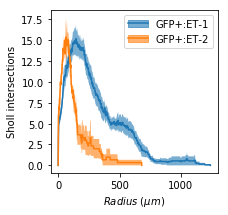

In [179]:
from neuron_cluster_analysis import plot_cluster_sholl
plot_cluster_sholl(
    pred_mpp,
    [c.name for c in gfp_c1_neurons],
    [c.name for c in gfp_c2_neurons],
    clusters=(0,1),sholl_part=False,
    label_map={0:'GFP+:ET-1',1:'GFP+:ET-2'},
    to_save='GFP+ c1_c2 sholl'
)

#### GFP- neurons

In [ ]:
pred_mpp2 = morpho_parser({
    "swc": "../../../reconstruction/predict/traces/GFP-_repair",
    "imaris": "../../../reconstruction/predict/stat/GFP-"
})

In [ ]:
pred_mpp2.plot_all_neurons()

In [ ]:
pred_mpp2.plot_apical_upside()

In [ ]:
control_morpho_dat=pred_mpp2.get_all_data()
control_morpho_dat.head()

In [ ]:
control_cluster=svm_f(control_morpho_dat)
control_morpho_dat['cluster'] = control_cluster
control_morpho_dat.head()

In [ ]:
control_c1_neurons=[
    n for n in pred_mpp2.neurons.neurons
    if n.name in control_morpho_dat[control_morpho_dat.cluster==0].reconstruction_ID.values
]
control_c2_neurons=[
    n for n in pred_mpp2.neurons.neurons
    if n.name in control_morpho_dat[control_morpho_dat.cluster==2].reconstruction_ID.values
]

In [ ]:
pred_mpp2.plot_apical_upside(control_c1_neurons)

In [ ]:
pred_mpp2.plot_apical_upside(control_c2_neurons)

In [ ]:
control_morpho_inter = analysor.stat_analyse(
    control_morpho_dat.drop(columns="reconstruction_ID"),
    group1=0,
    group2=2,
    test_small_sample=True,
)
control_morpho_inter[control_morpho_inter.p_value < 0.05].variable

In [ ]:
plot_cluster_stat(
    control_morpho_dat,'max_sholl_intercept_radii',
    clusters=(0,2),
    plot_box=True
)

In [ ]:
plot_cluster_stat(
    control_morpho_dat,'max_sholl_intercept_radii(apical)',
    clusters=(0,2),
    plot_box=True
)

In [ ]:
plot_cluster_stat(
    control_morpho_dat,'mean_local_bifurcation_angles',
    clusters=(0,2),
    plot_box=True
)

Sholl intersection of two clusters of GFP- neurons:

In [ ]:
from neuron_cluster_analysis import plot_cluster_sholl
plot_cluster_sholl(
    pred_mpp2,
    [c.name for c in control_c1_neurons],
    [c.name for c in control_c2_neurons],
    clusters=(0,2),sholl_part=False
)